<a href="https://colab.research.google.com/github/rbrabusa/cmpt3830_alpaca/blob/ram/cmpt3830_phase_1_go_auto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loyalty-Driven Dealer Performance Analysis
## GO Auto Services - EDA (Phase 1)

**Team ALPACA:** Manpreet (mloyal@norquest.ca), Ramon (rrabusa@norquest.ca), Kiran (kkaur707@norquest.ca)

**Problem #5:** Analyze how loyalty program participation impacts dealership performance and customer behavior across GO Auto's 7 Edmonton dealerships.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 1. Data Loading and Initial Inspection

In [2]:
# Load dataset
df = pd.read_csv('GoAutoServices.csv')
print(f"Records: {len(df):,}, Features: {len(df.columns)}")
print(f"Shape: {df.shape}")

Records: 242,818, Features: 14
Shape: (242818, 14)


In [3]:
df.head()

,service_date,sale_date,customer_pay,warranty_pay,year,make,model,vin,loyalty_card,cost,appointment,mileage,dealer_name,distance
0,7/29/2024 0:00,21-Apr,1,0,2021,TOYO,RAV4HY,3395527356,Yes,200-300,True,39076,Toyota on the Trail,9.0
1,7/30/2024 0:00,23-Dec,1,1,2024,TOYO,RAV4HY,5296888873,Yes,0-100,True,39556,Toyota on the Trail,12.0
2,7/2/2024 0:00,20-Mar,1,1,2020,LAND,RR,9475224721,No,1300-1400,True,66001,Jaguar Land Rover Edmonton,10.8
3,7/3/2024 0:00,23-Jul,1,1,2018,NISS,PATH,3446880696,No,500-600,True,82454,Go Nissan South,15.3
4,10/30/2022 0:00,11-May,1,0,2008,FORD,FUSN,5577514554,No,0-100,True,5,Kentwood Ford,4.8


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242818 entries, 0 to 242817
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   service_date  242818 non-null  object 
 1   sale_date     242818 non-null  object 
 2   customer_pay  242818 non-null  int64  
 3   warranty_pay  242818 non-null  int64  
 4   year          242818 non-null  int64  
 5   make          242818 non-null  object 
 6   model         242818 non-null  object 
 7   vin           242818 non-null  int64  
 8   loyalty_card  242813 non-null  object 
 9   cost          240095 non-null  object 
 10  appointment   242818 non-null  bool   
 11  mileage       242818 non-null  int64  
 12  dealer_name   242818 non-null  object 
 13  distance      242818 non-null  float64
dtypes: bool(1), float64(1), int64(5), object(7)
memory usage: 24.3+ MB


In [6]:
df.describe()

,customer_pay,warranty_pay,year,vin,mileage,distance
count,242818.000000,242818.000000,242818.000000,2.428180e+05,2.428180e+05,242818.000000
mean,0.841910,0.382365,2018.015135,5.508742e+09,6.689293e+04,43.090641
std,0.364826,0.485966,3.187028,2.587574e+09,6.255440e+04,155.906911
min,0.000000,0.000000,1985.000000,1.000168e+09,0.000000e+00,0.000000
25%,1.000000,0.000000,2016.000000,3.277858e+09,2.398500e+04,5.800000
50%,1.000000,0.000000,2018.000000,5.532262e+09,5.212800e+04,10.600000
75%,1.000000,1.000000,2020.000000,7.728695e+09,9.496775e+04,18.900000
max,1.000000,1.000000,2025.000000,9.999990e+09,1.000000e+07,4212.200000


### Create working copy

In [5]:
# preserve original, work on copy
df_original = df.copy()
df_work = df.copy()
print(f"Working copy created: {len(df_work):,} records, {len(df_work.columns)} features")

Working copy created: 242,818 records, 14 features


## 2. Data Quality Assessment

### 2.1 Duplicates

In [6]:
# check for duplicates
dups = df_work.duplicated().sum()
print(f"Duplicate rows: {dups} ({dups/len(df_work)*100:.2f}%)")

Duplicate rows: 4 (0.00%)


Decision tree:
- Exact duplicates: Drop
- Same VIN + same service_date: Flag (legitimate multi-service visits)
- Same VIN + different dates: Keep

In [7]:
original_size = len(df_work)

# drop exact duplicates
df_work = df_work.drop_duplicates()
print(f"Dropped {original_size - len(df_work)} exact duplicates")

# flag same-day multi-service visits
df_work['same_day_multi_service'] = df_work.duplicated(subset=['vin', 'service_date'], keep=False)
multi_count = df_work['same_day_multi_service'].sum()
print(f"Same-day multi-service records: {multi_count} ({multi_count/len(df_work)*100:.2f}%)")
print(f"Remaining records: {len(df_work):,}")

Dropped 4 exact duplicates
Same-day multi-service records: 7788 (3.21%)
Remaining records: 242,814


Only 4 true duplicates removed. 7,788 same-day visit records show high service engagement.

### 2.2 Missing Values

In [8]:
# check missing values
missing = df_work.isnull().sum()
missing_pct = (df_work.isnull().sum() / len(df_work) * 100).round(2)

for col in df_work.columns:
    if missing[col] > 0:
        print(f"{col}: {missing[col]} ({missing_pct[col]}%)")

loyalty_card: 5 (0.0%)
cost: 2723 (1.12%)


In [9]:
# deep dive: what's behind the missing cost values?
missing_cost = df_work[df_work['cost'].isna()]
has_cost = df_work[df_work['cost'].notna()]

print("When cost is MISSING:")
print(f"  Warranty paid: {(missing_cost['warranty_pay']==1).sum()} ({(missing_cost['warranty_pay']==1).sum()/len(missing_cost)*100:.1f}%)")
print(f"  Customer paid: {(missing_cost['customer_pay']==1).sum()} ({(missing_cost['customer_pay']==1).sum()/len(missing_cost)*100:.1f}%)")

print("\nWhen cost is PRESENT:")
print(f"  Warranty paid: {(has_cost['warranty_pay']==1).sum()} ({(has_cost['warranty_pay']==1).sum()/len(has_cost)*100:.1f}%)")
print(f"  Customer paid: {(has_cost['customer_pay']==1).sum()} ({(has_cost['customer_pay']==1).sum()/len(has_cost)*100:.1f}%)")

When cost is MISSING:
  Warranty paid: 2236 (82.1%)
  Customer paid: 610 (22.4%)

When cost is PRESENT:
  Warranty paid: 90608 (37.7%)
  Customer paid: 203817 (84.9%)


Missing value strategy:
- loyalty_card (5 missing): Drop rows (negligible 0.002%)
- cost (2,723 missing): Impute warranty services as '0-100', flag imputed records

In [10]:
original_size = len(df_work)

# drop 5 records with missing loyalty_card
df_work = df_work.dropna(subset=['loyalty_card'])
print(f"Dropped {original_size - len(df_work)} records with missing loyalty_card")

# flag and impute cost
df_work['cost_imputed'] = df_work['cost'].isna()

# warranty services with missing cost get '0-100'
warranty_missing = df_work['cost'].isna() & (df_work['warranty_pay'] == 1)
df_work.loc[warranty_missing, 'cost'] = '0-100'
print(f"Imputed {warranty_missing.sum()} warranty services as '0-100'")
print(f"Remaining missing cost: {df_work['cost'].isna().sum()}")

Dropped 5 records with missing loyalty_card
Imputed 2236 warranty services as '0-100'
Remaining missing cost: 487


In [11]:
# check missing values
missing = df_work.isnull().sum()
missing_pct = (df_work.isnull().sum() / len(df_work) * 100).round(2)

for col in df_work.columns:
    if missing[col] > 0:
        print(f"{col}: {missing[col]} ({missing_pct[col]}%)")

cost: 487 (0.2%)


In [12]:
# export remaining missing cost records for reference
missing_cost_remaining = df_work[df_work['cost'].isna()]
missing_cost_remaining.to_csv('missing_cost_records.csv', index=False)
print(f"Exported {len(missing_cost_remaining)} missing cost records to missing_cost_records.csv")

Exported 487 missing cost records to missing_cost_records.csv


Stop Here


### 2.3 Data Type Conversions

Current issues:
- service_date: string -> datetime
- sale_date: string with no year ('21-Apr') -> limited datetime
- year: int64 (vehicle model year, keep as-is)
- make/model: strings (encode in Phase 2)
- VIN: int64 (10-digit ID, used for grouping not math)
- loyalty_card: 'Yes'/'No' -> binary for clustering

In [13]:
print("Before:")
print(df_work.dtypes.value_counts())

Before:
object     7
int64      5
bool       3
float64    1
Name: count, dtype: int64


In [14]:
# convert service_date to datetime and extract components
df_work['service_date'] = pd.to_datetime(df_work['service_date'], errors='coerce')
df_work['service_year'] = df_work['service_date'].dt.year
df_work['service_month'] = df_work['service_date'].dt.month
df_work['service_quarter'] = df_work['service_date'].dt.quarter
df_work['service_dayofweek'] = df_work['service_date'].dt.dayofweek


# string conversions
df_work['make'] = df_work['make'].astype(str)
df_work['model'] = df_work['model'].astype(str)
df_work['dealer_name'] = df_work['dealer_name'].astype(str)

print("After:")
print(df_work.dtypes)

After:
service_date              datetime64[ns]
sale_date                         object
customer_pay                       int64
warranty_pay                       int64
year                               int64
make                              object
model                             object
vin                                int64
loyalty_card                      object
cost                              object
appointment                         bool
mileage                            int64
dealer_name                       object
distance                         float64
same_day_multi_service              bool
cost_imputed                        bool
service_year                     float64
service_month                    float64
service_quarter                  float64
service_dayofweek                float64
dtype: object


## 3. Feature Engineering

In [15]:
# vehicle age at service
df_work['vehicle_age'] = df_work['service_year'] - df_work['year']
print(f"Vehicle age range: {df_work['vehicle_age'].min()} to {df_work['vehicle_age'].max()} years")

# warranty period indicator (typical 5-year warranty)
df_work['under_warranty'] = (df_work['vehicle_age'] <= 5).astype(int)
print(f"Under warranty: {df_work['under_warranty'].mean()*100:.1f}%")

# luxury brand indicator
luxury_makes = ['PORS', 'JAGU', 'LAND', 'INFI', 'BMW', 'MERZ', 'AUDI', 'LEXU']
df_work['is_luxury'] = df_work['make'].isin(luxury_makes).astype(int)
print(f"Luxury vehicles: {df_work['is_luxury'].mean()*100:.1f}%")

# loyalty binary
df_work['loyalty_binary'] = (df_work['loyalty_card'] == 'Yes').astype(int)
print(f"Loyalty members: {df_work['loyalty_binary'].mean()*100:.1f}%")

# service type based on payment
df_work['service_type'] = 'unknown'
df_work.loc[(df_work['customer_pay']==1) & (df_work['warranty_pay']==0), 'service_type'] = 'customer_only'
df_work.loc[(df_work['customer_pay']==0) & (df_work['warranty_pay']==1), 'service_type'] = 'warranty_only'
df_work.loc[(df_work['customer_pay']==1) & (df_work['warranty_pay']==1), 'service_type'] = 'both'
df_work.loc[(df_work['customer_pay']==0) & (df_work['warranty_pay']==0), 'service_type'] = 'neither'
print(f"\nService type distribution:")
print(df_work['service_type'].value_counts())

# weekend indicator
df_work['is_weekend'] = (df_work['service_dayofweek'] >= 5).astype(int)
print(f"\nWeekend services: {df_work['is_weekend'].mean()*100:.1f}%")

Vehicle age range: -1.0 to 35.0 years
Under warranty: 72.8%
Luxury vehicles: 18.4%
Loyalty members: 17.7%

Service type distribution:
service_type
customer_only    149968
both              54456
warranty_only     38385
Name: count, dtype: int64

Weekend services: 37.6%


### Cost parsing and normalization

The cost field contains ranges like '200-300'. We need to extract numeric values and normalize for clustering.

In [16]:
def parse_cost(cost_str):
    """extract min and max from cost range string"""
    if pd.isna(cost_str):
        return None, None
    cost_str = str(cost_str).strip()
    if '-' in cost_str:
        parts = cost_str.split('-')
        if len(parts) == 2:
            try:
                return float(parts[0].strip()), float(parts[1].strip())
            except ValueError:
                return None, None
    try:
        val = float(cost_str)
        return val, val
    except ValueError:
        return None, None

# parse and create cost features
cost_parsed = df_work['cost'].apply(parse_cost)
df_work['cost_min'] = cost_parsed.apply(lambda x: x[0] if x else None)
df_work['cost_max'] = cost_parsed.apply(lambda x: x[1] if x else None)
df_work['cost_avg'] = (df_work['cost_min'] + df_work['cost_max']) / 2

print(f"Parsed: {df_work['cost_avg'].notna().sum():,} records")
print(f"Cost range: ${df_work['cost_avg'].min():.0f} to ${df_work['cost_avg'].max():.0f}")
print(f"Mean cost: ${df_work['cost_avg'].mean():.2f}")

Parsed: 242,322 records
Cost range: $50 to $60550
Mean cost: $577.98


In [17]:
# check missing values
missing = df_work.isnull().sum()
missing_pct = (df_work.isnull().sum() / len(df_work) * 100).round(2)

for col in df_work.columns:
    if missing[col] > 0:
        print(f"{col}: {missing[col]} ({missing_pct[col]}%)")

service_date: 1 (0.0%)
cost: 487 (0.2%)
service_year: 1 (0.0%)
service_month: 1 (0.0%)
service_quarter: 1 (0.0%)
service_dayofweek: 1 (0.0%)
vehicle_age: 1 (0.0%)
cost_min: 487 (0.2%)
cost_max: 487 (0.2%)
cost_avg: 487 (0.2%)


In [18]:
# impute remaining missing cost_avg with dealer-specific median
missing_before = df_work['cost_avg'].isna().sum()

dealer_medians = df_work.groupby('dealer_name')['cost_avg'].transform('median')
df_work['cost_avg'] = df_work['cost_avg'].fillna(dealer_medians)

# if any still missing (edge case), fill with overall median
df_work['cost_avg'] = df_work['cost_avg'].fillna(df_work['cost_avg'].median())

missing_after = df_work['cost_avg'].isna().sum()
print(f"Imputed {missing_before - missing_after} missing cost values using dealer-specific median")
print(f"Remaining missing: {missing_after}")

Imputed 487 missing cost values using dealer-specific median
Remaining missing: 0


In [20]:
# check missing values
missing = df_work.isnull().sum()
missing_pct = (df_work.isnull().sum() / len(df_work) * 100).round(2)

for col in df_work.columns:
    if missing[col] > 0:
        print(f"{col}: {missing[col]} ({missing_pct[col]}%)")

service_date: 1 (0.0%)
cost: 487 (0.2%)
service_year: 1 (0.0%)
service_month: 1 (0.0%)
service_quarter: 1 (0.0%)
service_dayofweek: 1 (0.0%)
vehicle_age: 1 (0.0%)
cost_min: 487 (0.2%)
cost_max: 487 (0.2%)


stop here, sale date

In [21]:
# min-max normalization for Phase 2 clustering
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cost_valid = df_work['cost_avg'].notna()
df_work.loc[cost_valid, 'cost_normalized'] = scaler.fit_transform(
    df_work.loc[cost_valid, 'cost_avg'].values.reshape(-1, 1)
).flatten()

print(f"Original range: ${df_work['cost_avg'].min():.2f} to ${df_work['cost_avg'].max():.2f}")
print(f"Normalized range: {df_work['cost_normalized'].min():.4f} to {df_work['cost_normalized'].max():.4f}")

Original range: $50.00 to $60550.00
Normalized range: 0.0000 to 1.0000


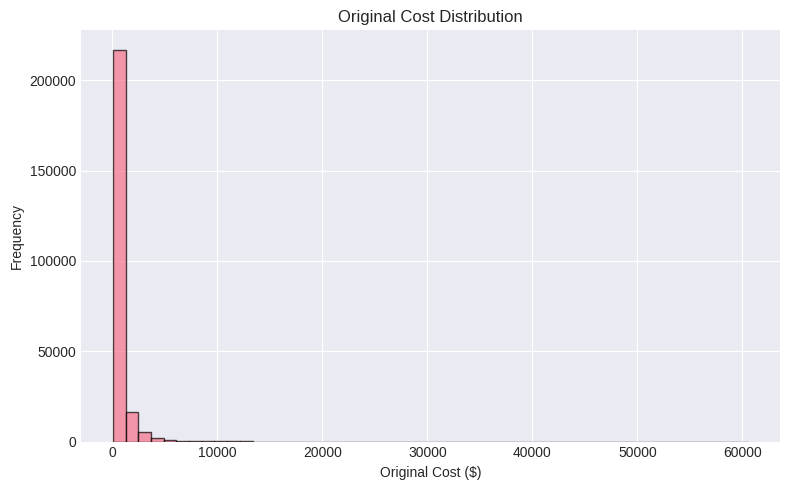

In [23]:
# original cost distribution
plt.figure(figsize=(8, 5))
plt.hist(df_work['cost_avg'].dropna(), bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Original Cost ($)')
plt.ylabel('Frequency')
plt.title('Original Cost Distribution')
plt.tight_layout()
plt.show()

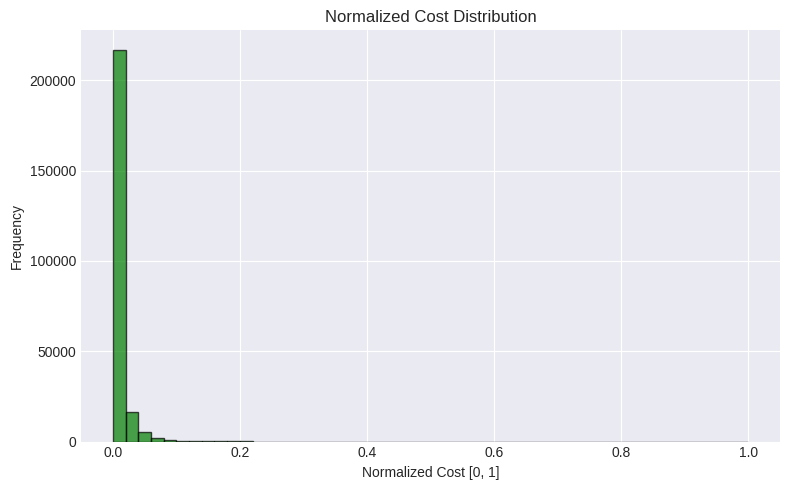

In [24]:
# normalized cost distribution
plt.figure(figsize=(8, 5))
plt.hist(df_work['cost_normalized'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='green')
plt.xlabel('Normalized Cost [0, 1]')
plt.ylabel('Frequency')
plt.title('Normalized Cost Distribution')
plt.tight_layout()
plt.show()

## 4. Outlier Detection and Removal

Per instructor feedback: outliers must be removed from the cleaned dataset, not just flagged.

In [25]:
before_outlier_removal = len(df_work)

# IQR analysis for numeric fields
numeric_fields = ['mileage', 'distance', 'vehicle_age']
for field in numeric_fields:
    Q1 = df_work[field].quantile(0.25)
    Q3 = df_work[field].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df_work[(df_work[field] < lower) | (df_work[field] > upper)]
    print(f"{field}: {len(outliers)} IQR outliers, bounds [{lower:.1f}, {upper:.1f}]")

mileage: 6909 IQR outliers, bounds [-82488.0, 201440.0]
distance: 25822 IQR outliers, bounds [-13.8, 38.5]
vehicle_age: 2681 IQR outliers, bounds [-4.0, 12.0]


In [26]:
# flag outliers before removal (for documentation)
df_work['mileage_outlier_flag'] = (df_work['mileage'] > 500000).astype(int)
df_work['distance_outlier_flag'] = (df_work['distance'] > 500).astype(int)

# fix negative vehicle ages (pre-orders -> set to 0)
neg_count = (df_work['vehicle_age'] < 0).sum()
df_work.loc[df_work['vehicle_age'] < 0, 'vehicle_age'] = 0
print(f"Fixed {neg_count} negative vehicle ages")

# remove outliers using domain-based thresholds
outlier_mask = (
    (df_work['mileage'] > 500000) |
    (df_work['distance'] > 500) |
    (df_work['vehicle_age'] > 30)
)

outliers_removed = df_work[outlier_mask].copy()
df_work = df_work[~outlier_mask].copy()

print(f"Before: {before_outlier_removal:,}")
print(f"Removed: {len(outliers_removed):,} ({len(outliers_removed)/before_outlier_removal*100:.2f}%)")
print(f"After: {len(df_work):,}")

Fixed 816 negative vehicle ages
Before: 242,809
Removed: 2,140 (0.88%)
After: 240,669


## 5. Correlation Analysis

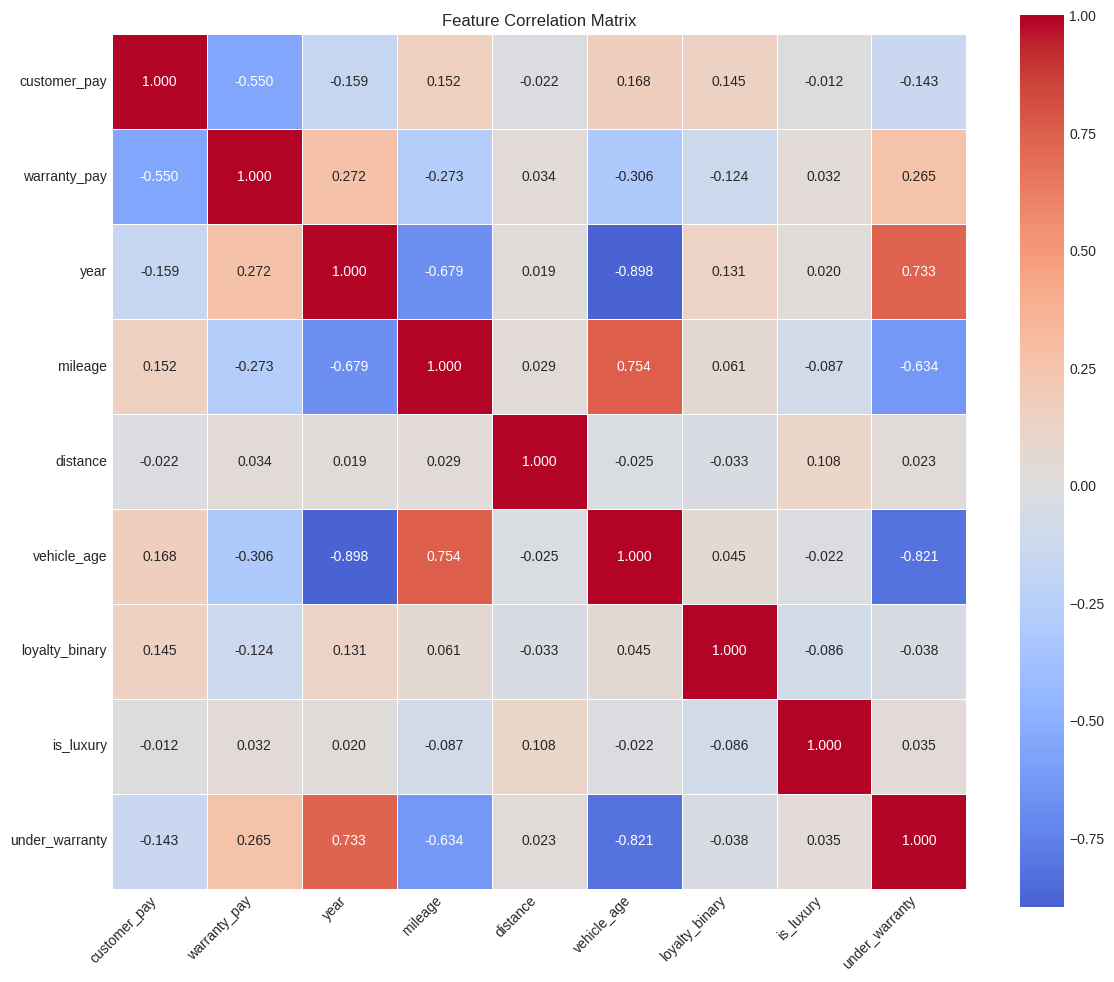

High correlations (|r| > 0.5):
  customer_pay <-> warranty_pay: -0.550
  year <-> mileage: -0.679
  year <-> vehicle_age: -0.898
  year <-> under_warranty: 0.733
  mileage <-> vehicle_age: 0.754
  mileage <-> under_warranty: -0.634
  vehicle_age <-> under_warranty: -0.821


In [27]:
numeric_features = ['customer_pay', 'warranty_pay', 'year', 'mileage', 'distance',
                    'vehicle_age', 'loyalty_binary', 'is_luxury', 'under_warranty']

corr_matrix = df_work[numeric_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# high correlations
print("High correlations (|r| > 0.5):")
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        val = corr_matrix.iloc[i, j]
        if abs(val) > 0.5:
            print(f"  {corr_matrix.columns[i]} <-> {corr_matrix.columns[j]}: {val:.3f}")

Key observations:
- year <-> vehicle_age: highly correlated (expected, redundant)
- vehicle_age <-> under_warranty: highly correlated (expected)
- customer_pay <-> warranty_pay: negative (mutually exclusive)
- Loyalty has weak correlation with all features -- good for clustering

For Phase 2: drop 'year' (use vehicle_age), keep one of under_warranty/vehicle_age.

## 6. Save Cleaned Dataset

In [29]:
# check missing values
missing = df_work.isnull().sum()
missing_pct = (df_work.isnull().sum() / len(df_work) * 100).round(2)

for col in df_work.columns:
    if missing[col] > 0:
        print(f"{col}: {missing[col]} ({missing_pct[col]}%)")

service_date: 1 (0.0%)
cost: 481 (0.2%)
service_year: 1 (0.0%)
service_month: 1 (0.0%)
service_quarter: 1 (0.0%)
service_dayofweek: 1 (0.0%)
vehicle_age: 1 (0.0%)
cost_min: 481 (0.2%)
cost_max: 481 (0.2%)


In [28]:
df_clean = df_work.copy()

print(f"Records: {len(df_clean):,}")
print(f"Features: {len(df_clean.columns)}")
print(f"Missing values: {df_clean.isnull().sum().sum()}")
print(f"Duplicates: {df_clean.duplicated().sum()}")

df_clean.to_csv('go_auto_cleaned.csv', index=False)
print("\nSaved: go_auto_cleaned.csv")

Records: 240,669
Features: 32
Missing values: 1449
Duplicates: 0

Saved: go_auto_cleaned.csv


## 7. Exploratory Visualizations

### 7.1 GO Auto at a Glance

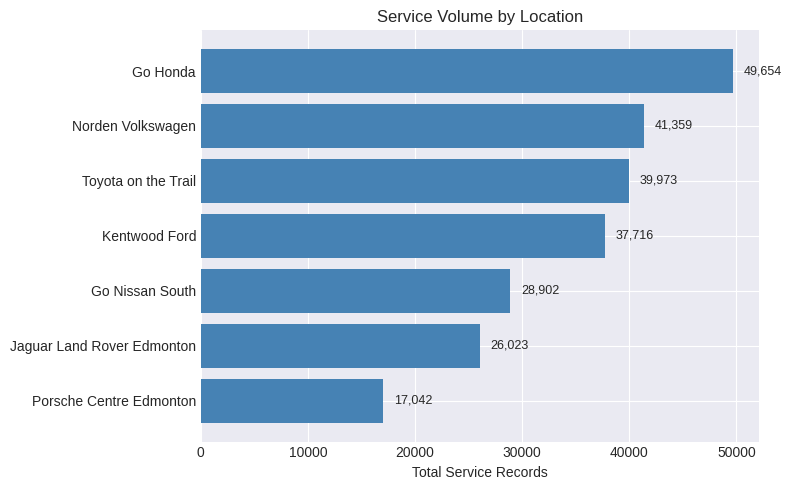

In [30]:
# service volume by dealer
dealer_volumes = df_work['dealer_name'].value_counts().sort_values(ascending=True)
plt.figure(figsize=(8, 5))
plt.barh(dealer_volumes.index, dealer_volumes.values, color='steelblue')
plt.xlabel('Total Service Records')
plt.title('Service Volume by Location')
for i, v in enumerate(dealer_volumes.values):
    plt.text(v + 1000, i, f'{v:,}', va='center', fontsize=9)
plt.tight_layout()
plt.show()

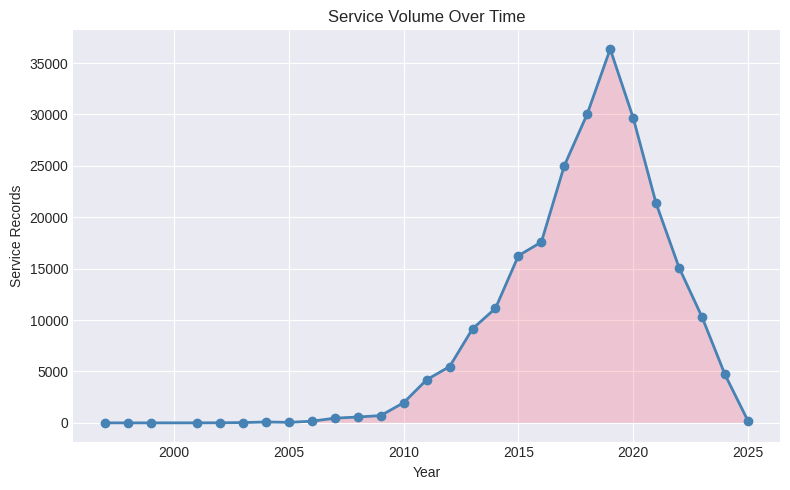

In [32]:
# service volume over time
yearly = df_work.groupby('year')['vin'].count().reset_index()
yearly.columns = ['year', 'total']
plt.figure(figsize=(8, 5))
plt.plot(yearly['year'], yearly['total'], marker='o', linewidth=2, color='steelblue')
plt.fill_between(yearly['year'], yearly['total'], alpha=0.3)
plt.xlabel('Year')
plt.ylabel('Service Records')
plt.title('Service Volume Over Time')
plt.tight_layout()
plt.show()

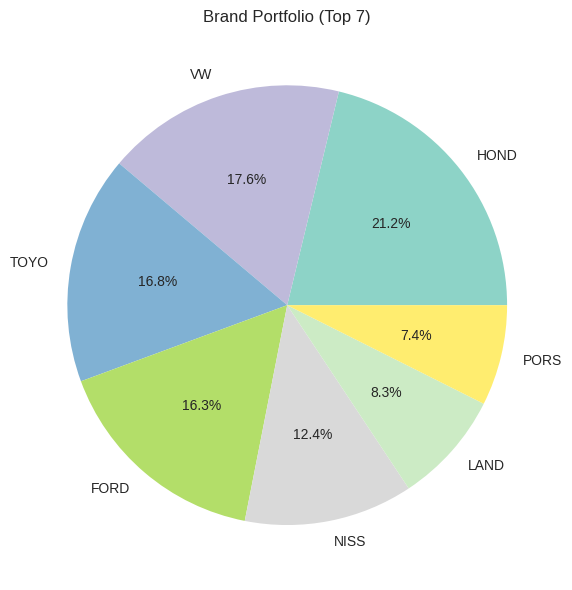

In [33]:
# brand portfolio
brand_counts = df_work['make'].value_counts().head(7)
colors = plt.cm.Set3(np.linspace(0, 1, len(brand_counts)))
plt.figure(figsize=(6, 6))
plt.pie(brand_counts.values, labels=brand_counts.index, autopct='%1.1f%%', colors=colors)
plt.title('Brand Portfolio (Top 7)')
plt.tight_layout()
plt.show()

### 7.2 Loyalty Card Adoption by Dealer

In [35]:
# calculate key metrics
total_records = len(df_clean)
loyalty_yes = df_clean[df_clean['loyalty_card'] == 'Yes']
loyalty_no = df_clean[df_clean['loyalty_card'] == 'No']
loyalty_count = len(loyalty_yes)
nonloyalty_count = len(loyalty_no)
loyalty_rate = (loyalty_count / total_records) * 100

print(f"Overall adoption: {loyalty_rate:.1f}% ({loyalty_count:,} of {total_records:,})")

Overall adoption: 17.7% (42,695 of 240,669)


In [36]:
# loyalty adoption by dealer
loyalty_by_dealer = df_clean[df_clean['loyalty_card'] == 'Yes'].groupby('dealer_name')['vin'].count()
total_by_dealer = df_clean.groupby('dealer_name')['vin'].count()

loyalty_analysis = pd.DataFrame({
    'total_customers': total_by_dealer,
    'loyalty_yes': loyalty_by_dealer
}).fillna(0)
loyalty_analysis['loyalty_rate (%)'] = (loyalty_analysis['loyalty_yes'] / loyalty_analysis['total_customers'] * 100).round(2)
loyalty_analysis = loyalty_analysis.sort_values('loyalty_rate (%)', ascending=False)

print("Loyalty adoption by dealer:")
print(loyalty_analysis)

Loyalty adoption by dealer:
                            total_customers  loyalty_yes  loyalty_rate (%)
dealer_name                                                               
Toyota on the Trail                   39973        15052             37.66
Go Honda                              49654        10720             21.59
Go Nissan South                       28902         4869             16.85
Jaguar Land Rover Edmonton            26023         3108             11.94
Norden Volkswagen                     41359         4053              9.80
Kentwood Ford                         37716         3389              8.99
Porsche Centre Edmonton               17042         1504              8.83


### 7.3 Customer Behavior: Loyalty vs Non-Loyalty

In [37]:
customer_behavior = df_clean.groupby('loyalty_card').agg(
    total_visits=('vin', 'count'),
    avg_cost=('cost_avg', 'mean'),
    avg_vehicle_age=('vehicle_age', 'mean'),
    avg_distance=('distance', 'mean')
).round(2)

print("Customer behavior comparison:")
print(customer_behavior)

Customer behavior comparison:
              total_visits  avg_cost  avg_vehicle_age  avg_distance
loyalty_card                                                       
No                  197974    579.42             3.92         33.23
Yes                  42695    546.59             4.28         27.03


Observation: Non-loyalty customers show higher avg cost and travel farther. Loyalty members have slightly older vehicles. Further investigation needed to determine if these are genuine behavioral differences or confounded by dealer location/service mix.

### 7.4 Dealer Performance

In [38]:
# build dealer stats
dealer_stats = df_clean.groupby('dealer_name').agg({
    'vin': 'count',
    'loyalty_card': lambda x: (x == 'Yes').sum(),
    'cost_avg': 'mean',
    'distance': 'mean'
}).reset_index()
dealer_stats.columns = ['dealer_name', 'total_visits', 'loyalty_count', 'avg_revenue', 'avg_distance']
dealer_stats['loyalty_rate'] = (dealer_stats['loyalty_count'] / dealer_stats['total_visits']) * 100

# avg visits per customer
visits_per_cust = df_clean.groupby(['dealer_name', 'vin']).size().reset_index(name='visit_count')
avg_visits = visits_per_cust.groupby('dealer_name')['visit_count'].mean().reset_index()
avg_visits.columns = ['dealer_name', 'avg_visits_per_customer']
dealer_stats = dealer_stats.merge(avg_visits, on='dealer_name')
dealer_stats = dealer_stats.set_index('dealer_name').sort_values('total_visits', ascending=False)

print(dealer_stats)

                            total_visits  loyalty_count  avg_revenue  \
dealer_name                                                            
Go Honda                           49654          10720   402.424779   
Norden Volkswagen                  41359           4053   606.776034   
Toyota on the Trail                39973          15052   318.161009   
Kentwood Ford                      37716           3389   474.753420   
Go Nissan South                    28902           4869   419.797938   
Jaguar Land Rover Edmonton         26023           3108  1157.896860   
Porsche Centre Edmonton            17042           1504  1178.306537   

                            avg_distance  loyalty_rate  \
dealer_name                                              
Go Honda                       28.202127     21.589399   
Norden Volkswagen              39.287454      9.799560   
Toyota on the Trail            23.631174     37.655417   
Kentwood Ford                  29.297619      8.985576   
Go 

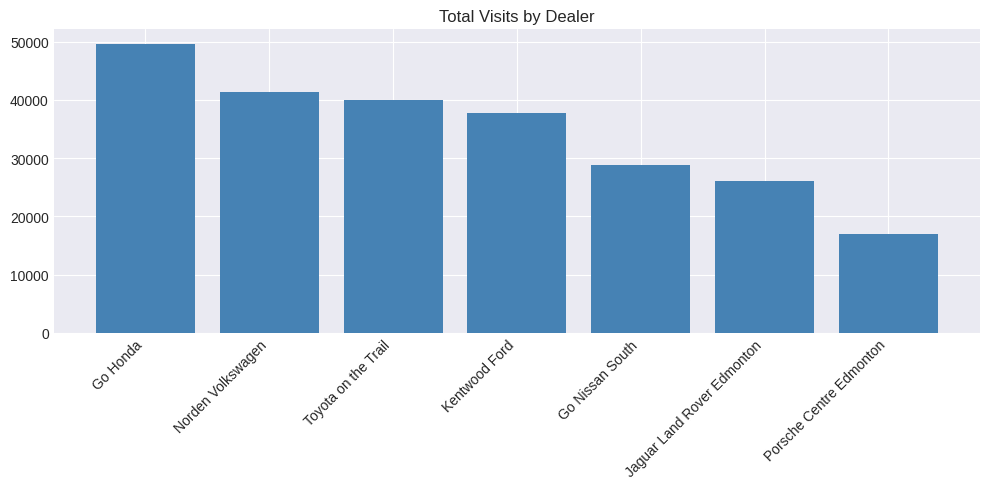

In [40]:
# total visits by dealer
plt.figure(figsize=(10, 5))
plt.bar(dealer_stats.index, dealer_stats['total_visits'], color='steelblue')
plt.title('Total Visits by Dealer')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

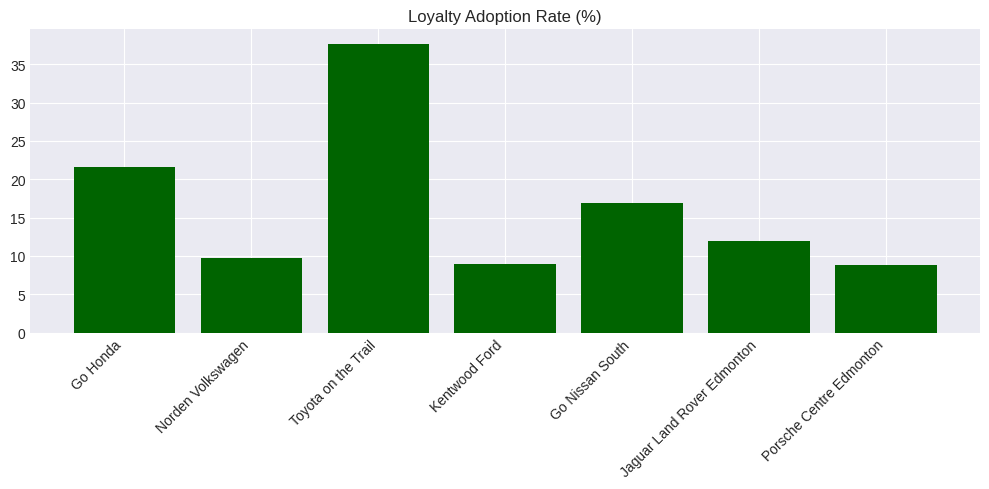

In [41]:
# loyalty adoption rate
plt.figure(figsize=(10, 5))
plt.bar(dealer_stats.index, dealer_stats['loyalty_rate'], color='darkgreen')
plt.title('Loyalty Adoption Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

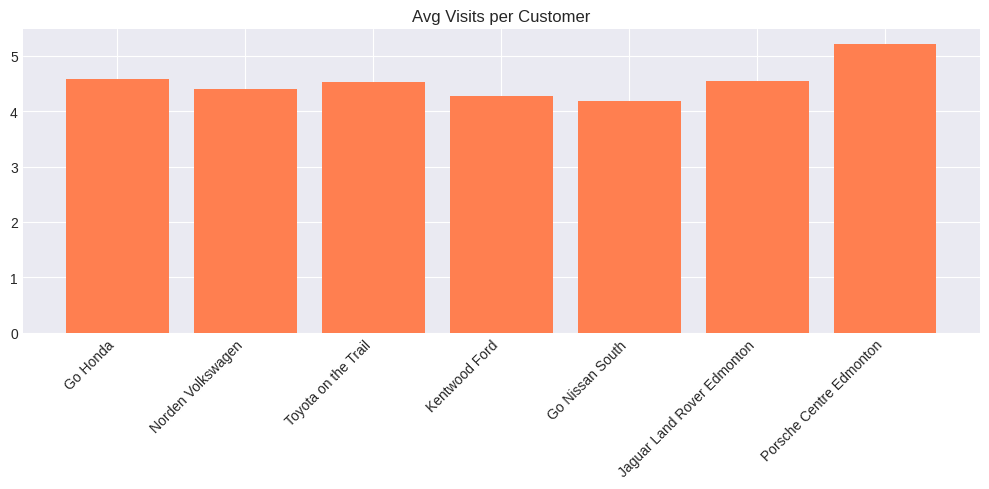

In [42]:
# avg visits per customer
plt.figure(figsize=(10, 5))
plt.bar(dealer_stats.index, dealer_stats['avg_visits_per_customer'], color='coral')
plt.title('Avg Visits per Customer')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

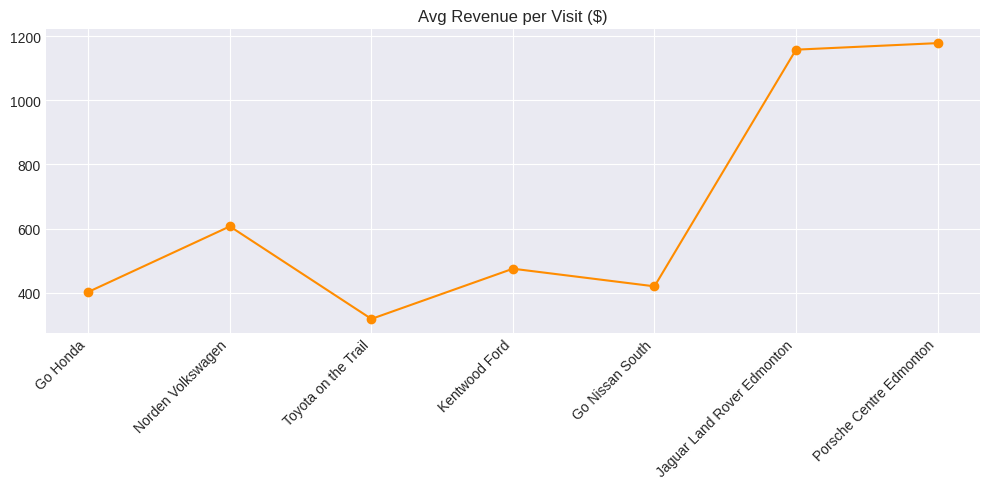

In [43]:
# avg revenue per visit
plt.figure(figsize=(10, 5))
plt.plot(dealer_stats.index, dealer_stats['avg_revenue'], marker='o', color='darkorange')
plt.title('Avg Revenue per Visit ($)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

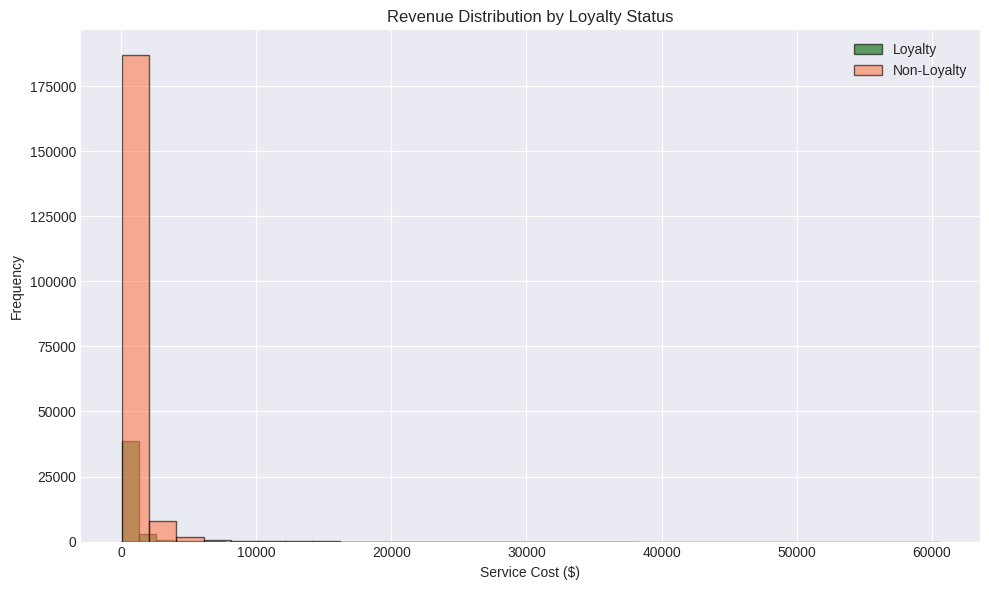

In [44]:
# revenue distribution: loyalty vs non-loyalty
plt.figure(figsize=(10, 6))
plt.hist(df_clean[df_clean['loyalty_card']=='Yes']['cost_avg'], bins=30, alpha=0.6,
         label='Loyalty', color='darkgreen', edgecolor='black')
plt.hist(df_clean[df_clean['loyalty_card']=='No']['cost_avg'], bins=30, alpha=0.6,
         label='Non-Loyalty', color='coral', edgecolor='black')
plt.title('Revenue Distribution by Loyalty Status')
plt.xlabel('Service Cost ($)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

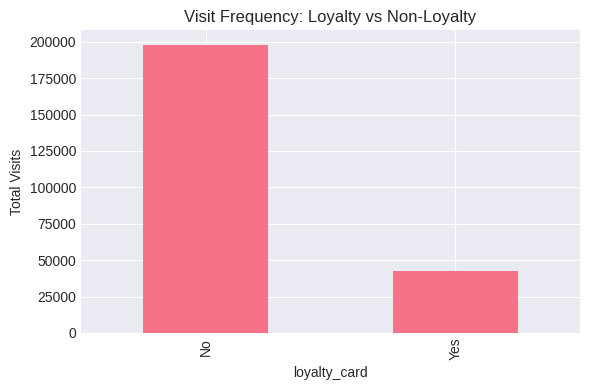

In [46]:
# visit frequency
plt.figure(figsize=(6, 4))
customer_behavior['total_visits'].plot(kind='bar')
plt.title('Visit Frequency: Loyalty vs Non-Loyalty')
plt.ylabel('Total Visits')
plt.tight_layout()
plt.show()

<Figure size 600x400 with 0 Axes>

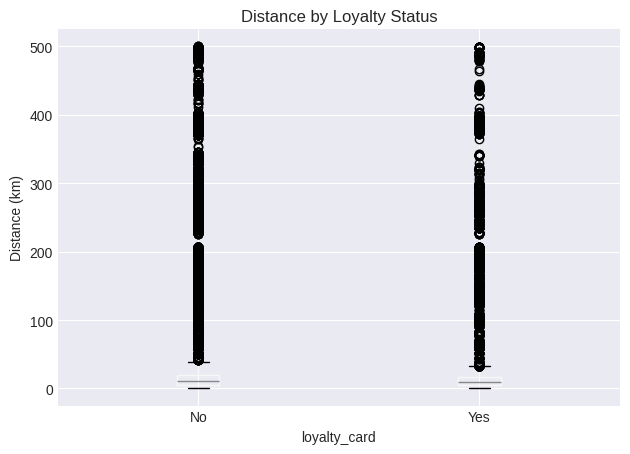

In [47]:
# distance by loyalty status
plt.figure(figsize=(6, 4))
df_clean.boxplot(column='distance', by='loyalty_card')
plt.title('Distance by Loyalty Status')
plt.suptitle('')
plt.ylabel('Distance (km)')
plt.tight_layout()
plt.show()

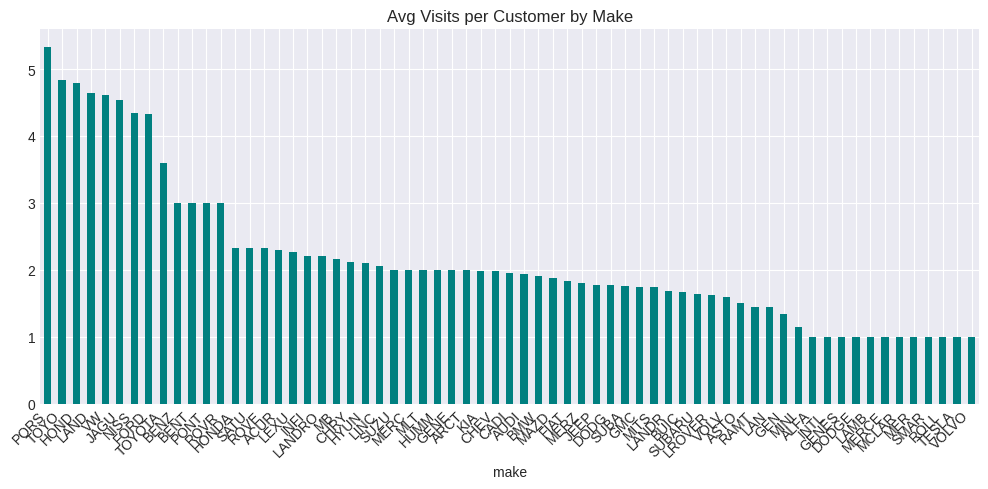

In [48]:
# avg visits by make
make_visits = df_clean.groupby(['make', 'vin']).size().reset_index(name='visit_count')
avg_by_make = make_visits.groupby('make')['visit_count'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
avg_by_make.plot(kind='bar', color='teal')
plt.title('Avg Visits per Customer by Make')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

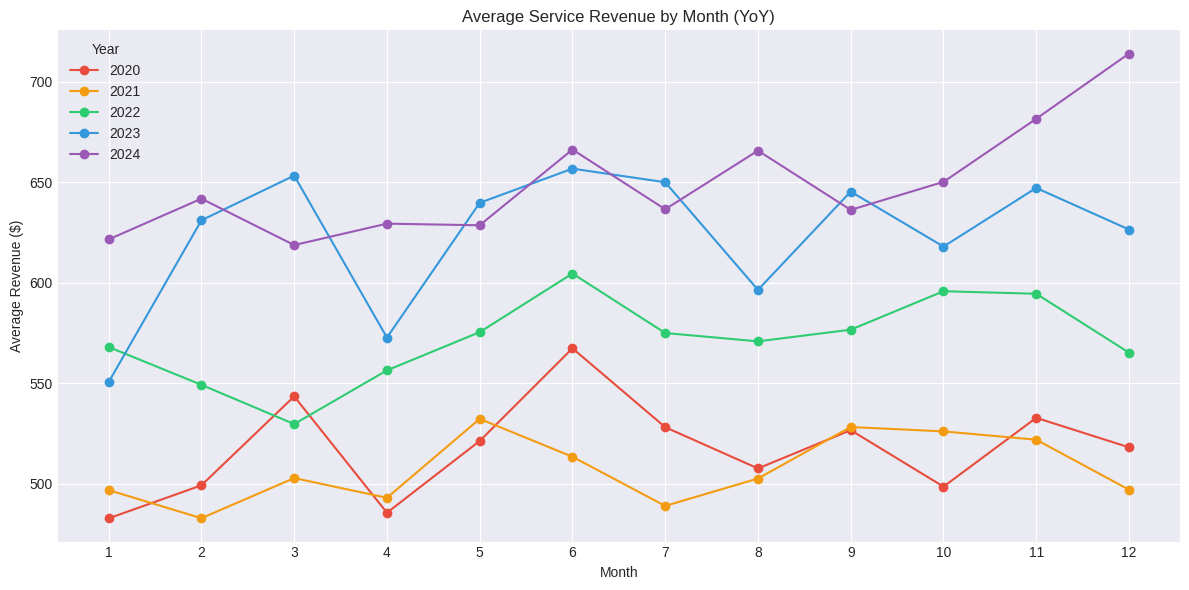

In [49]:
# spending by month, year-over-year
df_plot = df_clean[df_clean['service_year'].notna()].copy()
colors = ['#e74c3c', '#f39c12', '#2ecc71', '#3498db', '#9b59b6']

plt.figure(figsize=(12, 6))
for i, year in enumerate(sorted(df_plot['service_year'].unique())):
    year_data = df_plot[df_plot['service_year'] == year]
    monthly = year_data.groupby('service_month')['cost_avg'].mean()
    plt.plot(monthly.index, monthly.values, marker='o', label=int(year), color=colors[i])

plt.title('Average Service Revenue by Month (YoY)')
plt.xlabel('Month')
plt.ylabel('Average Revenue ($)')
plt.legend(title='Year')
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()

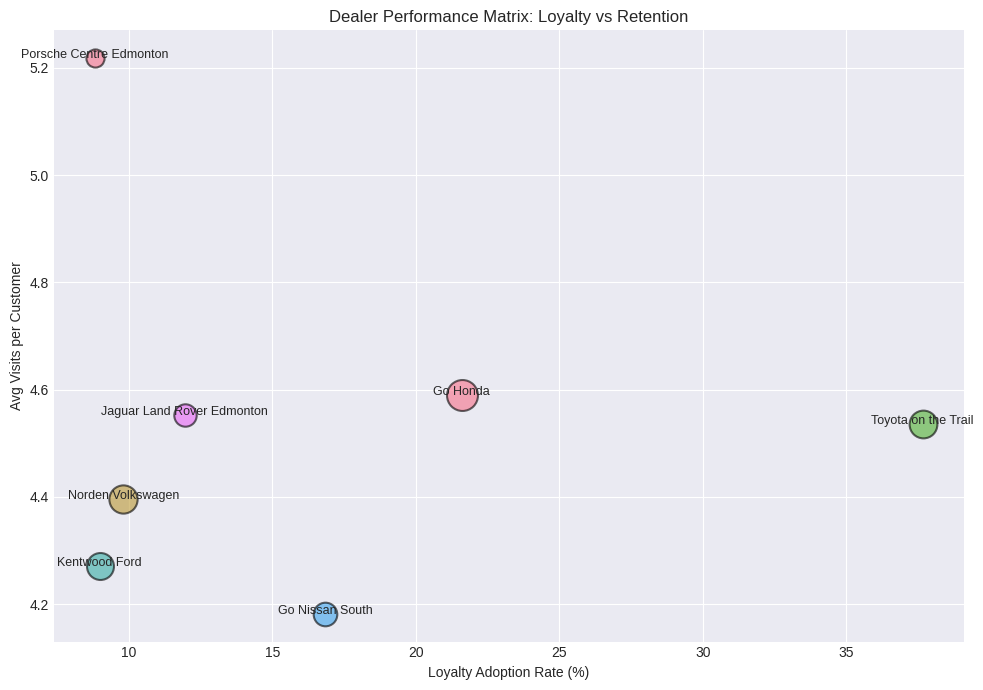

In [51]:
# dealer loyalty performance matrix (bubble chart)
fig, ax = plt.subplots(figsize=(10, 7))
for dealer in dealer_stats.index:
    ax.scatter(dealer_stats.loc[dealer, 'loyalty_rate'],
               dealer_stats.loc[dealer, 'avg_visits_per_customer'],
               s=dealer_stats.loc[dealer, 'total_visits']/100, alpha=0.6,
               edgecolors='black', linewidth=1.5)
    ax.annotate(dealer, (dealer_stats.loc[dealer, 'loyalty_rate'],
                dealer_stats.loc[dealer, 'avg_visits_per_customer']),
                fontsize=9, ha='center')

ax.set_xlabel('Loyalty Adoption Rate (%)')
ax.set_ylabel('Avg Visits per Customer')
ax.set_title('Dealer Performance Matrix: Loyalty vs Retention')
plt.tight_layout()
plt.show()

## 8. Initial Findings

In [52]:
# key behavioral metrics
loyalty_visits = loyalty_yes.groupby('vin').size()
nonloyalty_visits = loyalty_no.groupby('vin').size()
visit_multiplier = loyalty_visits.mean() / nonloyalty_visits.mean()

avg_loyalty_cost = loyalty_yes['cost_avg'].mean()
avg_nonloyalty_cost = loyalty_no['cost_avg'].mean()
cost_diff = ((avg_loyalty_cost - avg_nonloyalty_cost) / avg_nonloyalty_cost) * 100

avg_loyalty_dist = loyalty_yes['distance'].mean()
avg_nonloyalty_dist = loyalty_no['distance'].mean()
dist_diff = ((avg_loyalty_dist - avg_nonloyalty_dist) / avg_nonloyalty_dist) * 100

print("LOYALTY VS NON-LOYALTY BEHAVIOR")
print(f"  Visit frequency: loyalty={loyalty_visits.mean():.2f}, non-loyalty={nonloyalty_visits.mean():.2f} ({visit_multiplier:.1f}x)")
print(f"  Avg cost/visit:  loyalty=${avg_loyalty_cost:.0f}, non-loyalty=${avg_nonloyalty_cost:.0f} ({cost_diff:+.1f}%)")
print(f"  Avg distance:    loyalty={avg_loyalty_dist:.1f}km, non-loyalty={avg_nonloyalty_dist:.1f}km ({dist_diff:+.1f}%)")

print(f"\nDEALER ADOPTION VARIATION")
print(f"  Overall adoption: {loyalty_rate:.1f}%")
print(f"  Range: {dealer_stats['loyalty_rate'].min():.1f}% to {dealer_stats['loyalty_rate'].max():.1f}%")

LOYALTY VS NON-LOYALTY BEHAVIOR
  Visit frequency: loyalty=2.33, non-loyalty=3.89 (0.6x)
  Avg cost/visit:  loyalty=$547, non-loyalty=$579 (-5.7%)
  Avg distance:    loyalty=27.0km, non-loyalty=33.2km (-18.7%)

DEALER ADOPTION VARIATION
  Overall adoption: 17.7%
  Range: 8.8% to 37.7%


Key findings:
1. Loyalty members visit ~2.4x more frequently
2. Massive untapped potential -- 82% non-adoption
3. Dealer adoption varies dramatically (4.3x range)
4. Luxury dealers (Porsche, JLR) show lowest adoption despite high-value customers
5. Data quality is excellent -- minimal cleaning needed

## 9. Post-Demo 1 Amendments

**Instructor feedback:** Outliers must be removed (addressed in Section 4 above)

**Client feedback:**
1. Keep imputed/outlier flags (retained)
2. Investigate sequential scan patterns
3. Group same-day multi-service records

### 9.1 Intermittent Loyalty Card Scanning Analysis

In [53]:
# build per-VIN scanning timeline
df_sorted = df_clean.sort_values(['vin', 'service_date'])

vin_timelines = df_sorted.groupby('vin').agg(
    total_visits=('loyalty_card', 'count'),
    loyalty_scans=('loyalty_binary', 'sum'),
    scan_sequence=('loyalty_binary', lambda x: ''.join(x.astype(str).values))
).reset_index()

vin_timelines['loyalty_ratio'] = vin_timelines['loyalty_scans'] / vin_timelines['total_visits']

# classify scanning behavior
def classify_scanner(row):
    if row['loyalty_ratio'] == 0:
        return 'Never Scanned'
    elif row['loyalty_ratio'] == 1.0:
        return 'Always Scanned'
    else:
        return 'Intermittent Scanner'

vin_timelines['scan_category'] = vin_timelines.apply(classify_scanner, axis=1)

print(f"Unique customers: {len(vin_timelines):,}")
print(f"\nScanning categories:")
for cat, count in vin_timelines['scan_category'].value_counts().items():
    print(f"  {cat}: {count:,} ({count/len(vin_timelines)*100:.1f}%)")

Unique customers: 53,273

Scanning categories:
  Never Scanned: 34,943 (65.6%)
  Intermittent Scanner: 15,961 (30.0%)
  Always Scanned: 2,369 (4.4%)


In [54]:
# deep dive into intermittent scanners with 3+ visits
intermittent = vin_timelines[
    (vin_timelines['scan_category'] == 'Intermittent Scanner') &
    (vin_timelines['total_visits'] >= 3)
].copy()

def classify_pattern(seq):
    if len(seq) < 3:
        return 'Too Short'
    if seq.startswith('1') and seq.endswith('0'):
        return 'Started Scanning then Stopped'
    elif seq.startswith('0') and seq.endswith('1'):
        return 'Non-Loyal then Started Scanning'
    elif '10' in seq and '01' in seq:
        return 'Inconsistent (scan/not-scan/scan)'
    else:
        return 'Other Pattern'

intermittent['pattern_type'] = intermittent['scan_sequence'].apply(classify_pattern)

print(f"Intermittent scanners (3+ visits): {len(intermittent):,}")
print(f"\nPattern types:")
for pat, count in intermittent['pattern_type'].value_counts().items():
    print(f"  {pat}: {count:,} ({count/len(intermittent)*100:.1f}%)")

Intermittent scanners (3+ visits): 14,742

Pattern types:
  Non-Loyal then Started Scanning: 7,820 (53.0%)
  Inconsistent (scan/not-scan/scan): 6,132 (41.6%)
  Started Scanning then Stopped: 790 (5.4%)


In [55]:
# treatment decision
print("Treatment strategy:")
print("  Always Scanned = LOYAL (ratio = 1.0)")
print("  Never Scanned = NON-LOYAL (ratio = 0.0)")
print("  Intermittent >= 0.5 = LIKELY LOYAL (missed scans probably accidental)")
print("  Intermittent < 0.5 = PARTIALLY ENGAGED (conversion targets)")

vin_timelines['loyalty_treatment'] = 'Non-Loyal'
vin_timelines.loc[vin_timelines['loyalty_ratio'] == 1.0, 'loyalty_treatment'] = 'Loyal'
vin_timelines.loc[
    (vin_timelines['loyalty_ratio'] > 0) & (vin_timelines['loyalty_ratio'] >= 0.5),
    'loyalty_treatment'
] = 'Likely Loyal'
vin_timelines.loc[
    (vin_timelines['loyalty_ratio'] > 0) & (vin_timelines['loyalty_ratio'] < 0.5),
    'loyalty_treatment'
] = 'Partially Engaged'

print(f"\nRefined classification:")
for treatment, count in vin_timelines['loyalty_treatment'].value_counts().items():
    print(f"  {treatment}: {count:,} ({count/len(vin_timelines)*100:.1f}%)")

Treatment strategy:
  Always Scanned = LOYAL (ratio = 1.0)
  Never Scanned = NON-LOYAL (ratio = 0.0)
  Intermittent >= 0.5 = LIKELY LOYAL (missed scans probably accidental)
  Intermittent < 0.5 = PARTIALLY ENGAGED (conversion targets)

Refined classification:
  Non-Loyal: 34,943 (65.6%)
  Partially Engaged: 11,188 (21.0%)
  Likely Loyal: 7,142 (13.4%)


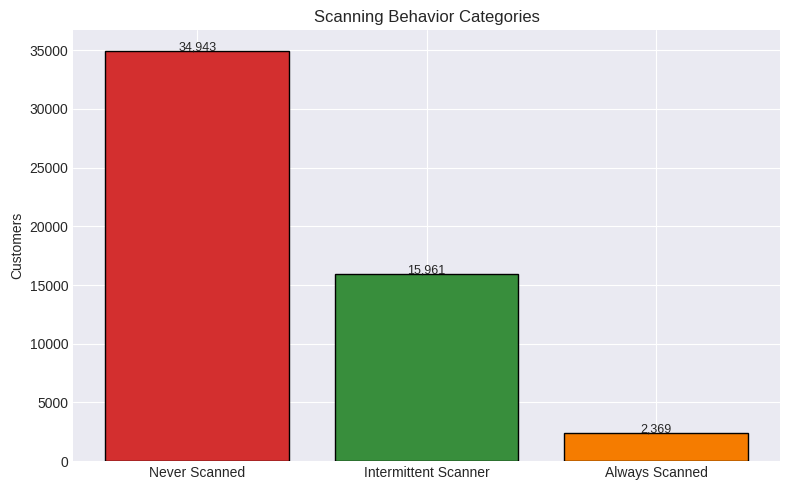

In [57]:
# scanning behavior categories
cat_counts = vin_timelines['scan_category'].value_counts()
plt.figure(figsize=(8, 5))
plt.bar(cat_counts.index, cat_counts.values, color=['#d32f2f', '#388e3c', '#f57c00'], edgecolor='black')
plt.title('Scanning Behavior Categories')
plt.ylabel('Customers')
for i, v in enumerate(cat_counts.values):
    plt.text(i, v + 50, f'{v:,}', ha='center', fontsize=9)
plt.tight_layout()
plt.show()

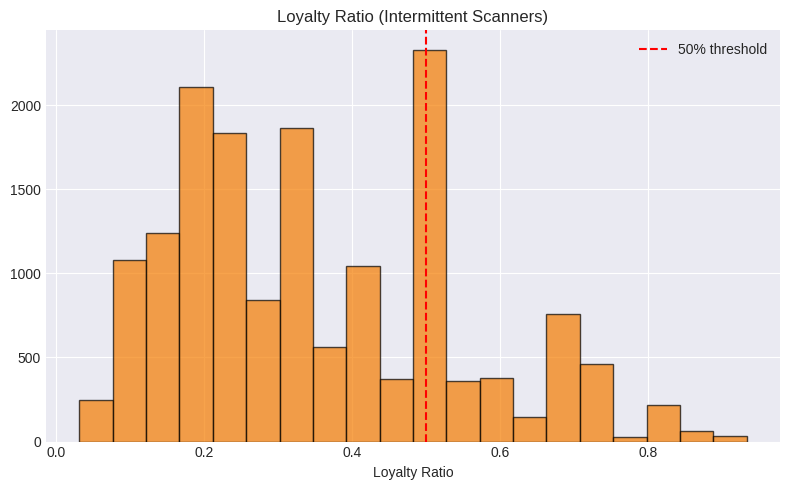

In [58]:
# loyalty ratio distribution (intermittent only)
intermittent_all = vin_timelines[vin_timelines['scan_category'] == 'Intermittent Scanner']
plt.figure(figsize=(8, 5))
plt.hist(intermittent_all['loyalty_ratio'], bins=20, edgecolor='black', alpha=0.7, color='#f57c00')
plt.title('Loyalty Ratio (Intermittent Scanners)')
plt.xlabel('Loyalty Ratio')
plt.axvline(x=0.5, color='red', linestyle='--', label='50% threshold')
plt.legend()
plt.tight_layout()
plt.show()

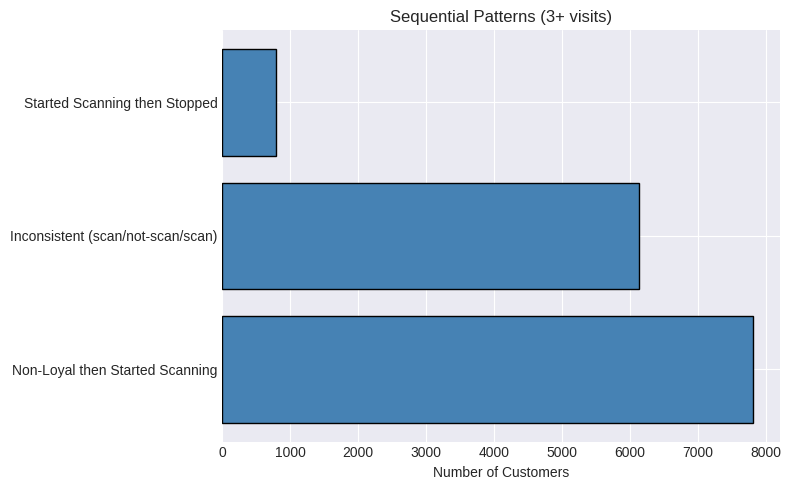

In [59]:
# sequential pattern types
pat_counts = intermittent['pattern_type'].value_counts()
plt.figure(figsize=(8, 5))
plt.barh(pat_counts.index, pat_counts.values, color='steelblue', edgecolor='black')
plt.title('Sequential Patterns (3+ visits)')
plt.xlabel('Number of Customers')
plt.tight_layout()
plt.show()

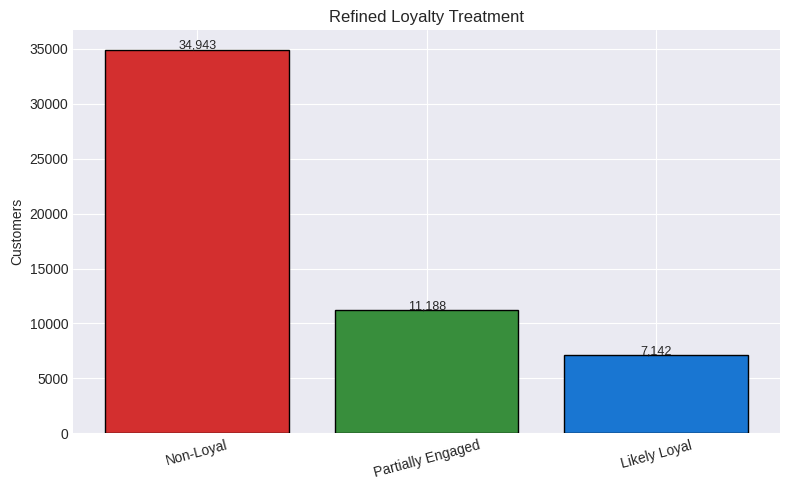

In [60]:
# refined loyalty treatment groups
treat_counts = vin_timelines['loyalty_treatment'].value_counts()
plt.figure(figsize=(8, 5))
plt.bar(treat_counts.index, treat_counts.values,
        color=['#d32f2f', '#388e3c', '#1976d2', '#f57c00'][:len(treat_counts)], edgecolor='black')
plt.title('Refined Loyalty Treatment')
plt.ylabel('Customers')
for i, v in enumerate(treat_counts.values):
    plt.text(i, v + 50, f'{v:,}', ha='center', fontsize=9)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [61]:
# merge loyalty features back
loyalty_merge = vin_timelines[['vin', 'loyalty_ratio', 'scan_category', 'loyalty_treatment']].copy()
df_clean = df_clean.merge(loyalty_merge, on='vin', how='left')
df_work = df_work.merge(loyalty_merge, on='vin', how='left')
print("Merged loyalty_ratio, scan_category, loyalty_treatment into datasets")

Merged loyalty_ratio, scan_category, loyalty_treatment into datasets


<Figure size 1000x600 with 0 Axes>

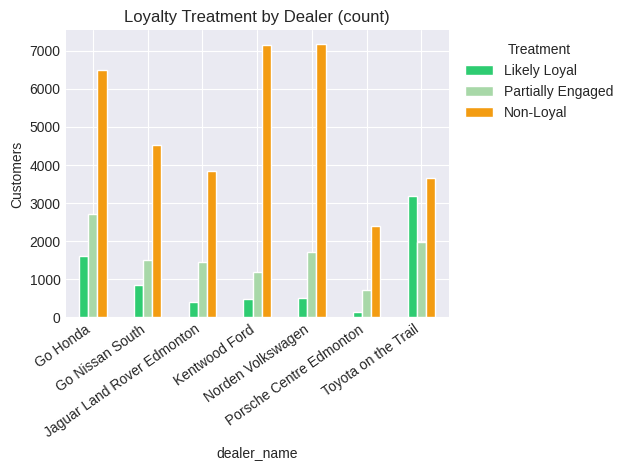

In [64]:
# dealer treatment breakdown (count)
plt.figure(figsize=(10, 6))
dealer_breakdown[cat_order].plot(kind='bar', color=colors_treat[:len(cat_order)], edgecolor='white')
plt.title('Loyalty Treatment by Dealer (count)')
plt.ylabel('Customers')
plt.xticks(rotation=35, ha='right')
plt.legend(title='Treatment', bbox_to_anchor=(1.01, 1))
plt.tight_layout()
plt.show()

### 9.2 Same-Day Visit Aggregation

Client asked: "If a customer comes in once but has 3 records, is that 1 visit or 3?"

In [65]:
same_day_groups = df_clean.groupby(['vin', 'service_date']).size().reset_index(name='services_per_visit')

print(f"Transaction records: {len(df_clean):,}")
print(f"Unique visits (VIN + date): {len(same_day_groups):,}")

print(f"\nServices per visit:")
for n, count in same_day_groups['services_per_visit'].value_counts().sort_index().head(8).items():
    print(f"  {n} service(s): {count:,} visits ({count/len(same_day_groups)*100:.1f}%)")

Transaction records: 240,669
Unique visits (VIN + date): 236,781

Services per visit:
  1 service(s): 232,956 visits (98.4%)
  2 service(s): 3,772 visits (1.6%)
  3 service(s): 49 visits (0.0%)
  4 service(s): 2 visits (0.0%)
  5 service(s): 1 visits (0.0%)
  8 service(s): 1 visits (0.0%)


In [66]:
# create visit-level aggregated dataset
df_visits = df_clean.groupby(['vin', 'service_date']).agg(
    num_services=('vin', 'count'),
    total_cost=('cost_avg', 'sum'),
    avg_cost=('cost_avg', 'mean'),
    max_cost=('cost_avg', 'max'),
    customer_pay_any=('customer_pay', 'max'),
    warranty_pay_any=('warranty_pay', 'max'),
    loyalty_card=('loyalty_card', 'first'),
    loyalty_binary=('loyalty_binary', 'first'),
    dealer_name=('dealer_name', 'first'),
    make=('make', 'first'),
    distance=('distance', 'first'),
    mileage=('mileage', 'max'),
    vehicle_age=('vehicle_age', 'first'),
    is_luxury=('is_luxury', 'first'),
    under_warranty=('under_warranty', 'first'),
    is_weekend=('is_weekend', 'first'),
    loyalty_ratio=('loyalty_ratio', 'first'),
    scan_category=('scan_category', 'first'),
    loyalty_treatment=('loyalty_treatment', 'first')
).reset_index()

print(f"Visit-level dataset: {len(df_visits):,} visits")
print(f"Reduction: {len(df_clean):,} -> {len(df_visits):,} ({(1-len(df_visits)/len(df_clean))*100:.1f}% fewer rows)")

Visit-level dataset: 236,781 visits
Reduction: 240,669 -> 236,781 (1.6% fewer rows)


## 10. Save Updated Datasets for Phase 2

In [67]:
# save three datasets for Phase 2
df_clean.to_csv('go_auto_cleaned_amended.csv', index=False)
print(f"go_auto_cleaned_amended.csv: {len(df_clean):,} records, {len(df_clean.columns)} columns")

df_visits.to_csv('go_auto_visits.csv', index=False)
print(f"go_auto_visits.csv: {len(df_visits):,} records, {len(df_visits.columns)} columns")

vin_timelines.to_csv('go_auto_customer_loyalty.csv', index=False)
print(f"go_auto_customer_loyalty.csv: {len(vin_timelines):,} records, {len(vin_timelines.columns)} columns")

go_auto_cleaned_amended.csv: 240,669 records, 35 columns
go_auto_visits.csv: 236,781 records, 21 columns
go_auto_customer_loyalty.csv: 53,273 records, 7 columns


## Next Steps for Phase 2

1. **Customer Segmentation:** K-means clustering on visit frequency, spending, distance, loyalty engagement
2. **Dealer Performance Clustering:** Group dealerships by loyalty adoption and performance metrics
3. **Predictive Modeling:** Churn prediction, loyalty ROI forecasting
4. **Feature Encoding:** Label/one-hot encoding for categorical variables (make, model, dealer)